# Comprehensive EDA: Online Retail II

This notebook focuses solely on exploratory detection, visualization, and issue spotting for the Online Retail II dataset. Any remediation, filtering, or feature engineering is deferred to `02_FeatureEngineering.ipynb`.

This notebook follows 10 sections :
1. **Data loading & preparation**
2. **Column description**
3. **Data quality checks**
4. **Univariate analysis**
5. **Time analysis**
6. **Customer identifier diagnostics**
7. **Product insights**
8. **Country insights**
9. **Visual anomaly detection**
10. **Conclusions for feature engineering**

In [29]:
# Imports & global configuration
import os
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.autolayout": True})

IMAGES_DIR = Path("../images")
os.makedirs(IMAGES_DIR, exist_ok=True)

def save_fig(name):
    plt.savefig(IMAGES_DIR / f"{name}.png", dpi=300, bbox_inches='tight')


## 1. Loading & preparation

- Read the raw dataset `online_retail_II.csv`.
- Apply cosmetic renaming and derive helper fields needed for visualizations.
- Create `df_clean = df.copy()` dedicated to the EDA workflow only.
- Display a quick snapshot plus shape/info/describe without altering the underlying data.

In [ ]:
# Load raw dataset and create working copy
DATA_PATH = Path("../data/raw/online_retail_II.csv")
df = pd.read_csv(DATA_PATH)
df.rename(columns={"Price": "UnitPrice", "Customer ID": "CustomerID"}, inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df_clean = df.copy()  # working copy for detection/visualization only
display(df_clean.head())

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [31]:
print(f"Shape: {df_clean.shape}")
df_clean.info()

Shape: (1067371, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   TotalPrice   1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 73.3+ MB


In [32]:
display(df_clean.describe(include='all'))

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
count,1067371,1067371,1062989,1.067371e+06,1067371,1.067371e+06,824364.000000,1067371,1.067371e+06
unique,53628,5305,5698,NaN,NaN,NaN,NaN,43,NaN
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,1350,5829,5918,NaN,NaN,NaN,NaN,981330,NaN
mean,NaN,NaN,NaN,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504,NaN,1.806987e+01
min,NaN,NaN,NaN,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,NaN,-1.684696e+05
25%,NaN,NaN,NaN,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000,NaN,3.750000e+00
50%,NaN,NaN,NaN,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,NaN,9.900000e+00
75%,NaN,NaN,NaN,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000,NaN,1.770000e+01
max,NaN,NaN,NaN,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,NaN,1.684696e+05


## 2. Column analysis

Each column is described below with its business meaning. The features kept for the customer clustering initiative are highlighted at the end.


### Column dictionary

- `Invoice`: unique invoice number that lets us rebuild transactions and compute purchase frequency.
- `StockCode`: SKU identifying each product sold in the catalogue.
- `Description`: product label used for reporting and for joining external taxonomies.
- `Quantity`: number of units sold (negative values correspond to returns and credit notes).
- `InvoiceDate`: timestamp of the transaction, required for time-series features and recency.
- `UnitPrice`: unit price in GBP at the time of sale.
- `CustomerID`: numeric customer identifier, essential for segmentation (can be missing for anonymous shoppers).
- `Country`: country of the customer or shipping destination.
- `TotalPrice`: derived feature equal to `Quantity × UnitPrice`, used for revenue-based metrics.

**Features kept for clustering:** `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`, `TotalPrice`.


## 3. Data quality checks

Only detection and quantification happen here. Identified issues are logged for later remediation while the dataset remains untouched.

### 3.1 Missing values

Quantify null counts per column to understand coverage.

In [33]:
# Percentage of missing values
missing_counts = df_clean.isna().sum()
missing_percent = (missing_counts / len(df_clean)) * 100
missing_df = (
    pd.DataFrame({"missing_count": missing_counts, "missing_percent": missing_percent})
    .sort_values(by="missing_percent", ascending=False)
)
display(missing_df)

,missing_count,missing_percent
CustomerID,243007,22.766873
Description,4382,0.410541
Invoice,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000
TotalPrice,0,0.000000


> CustomerID is the only field with substantial missing values (~23%), meaning many transactions cannot be associated with a customer and will need to be removed before segmentation.

### 3.2 Duplicates

Count potential duplicate rows to gauge de-duplication needs.

In [34]:
# Count and preview duplicates
duplicate_mask = df_clean.duplicated()
duplicate_count = duplicate_mask.sum()
print(f"Duplicated rows: {duplicate_count}")
if duplicate_count > 0:
    display(df_clean.loc[duplicate_mask].head())

Duplicated rows: 34335


,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom,5.10
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom,7.80
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75


> A noticeable number of duplicate rows appear in the dataset, likely caused by repeated system logs or reloaded transactions. Since duplicates artificially inflate quantities and revenue, they need to be removed during feature engineering. For EDA, we only quantify them to understand data quality issues without altering the working dataframe.

### 3.3 Negative quantities

Negative quantities often correspond to returns or adjustments.

In [35]:
# Return rate via negative quantities
returns_mask = df_clean['Quantity'] < 0
return_ratio = returns_mask.mean() * 100
print(f"Returns (Quantity < 0): {return_ratio:.2f}% of rows")
if returns_mask.any():
    display(df_clean.loc[returns_mask, ['Invoice', 'InvoiceDate', 'CustomerID', 'Quantity', 'UnitPrice', 'Country']].head())

Returns (Quantity < 0): 2.15% of rows


,Invoice,InvoiceDate,CustomerID,Quantity,UnitPrice,Country
178,C489449,2009-12-01 10:33:00,16321.0,-12,2.95,Australia
179,C489449,2009-12-01 10:33:00,16321.0,-6,1.65,Australia
180,C489449,2009-12-01 10:33:00,16321.0,-4,4.25,Australia
181,C489449,2009-12-01 10:33:00,16321.0,-6,2.10,Australia
182,C489449,2009-12-01 10:33:00,16321.0,-12,2.95,Australia


> Negative quantities represent product returns or order corrections. Their proportion is relatively small but non-negligible. These rows must be removed for modeling because they distort purchasing behaviour and would mislead RFM features, but they still provide insight into operational issues and seasonality of returns.

### 3.4 Cancellation invoices

Invoices starting with `C` are typically cancellations; quantify them without filtering anything out.

In [36]:
# Cancellation diagnostics
invoice_series = df_clean['Invoice'].astype(str)
cancellation_mask = invoice_series.str.startswith('C', na=False)
cancellation_count = cancellation_mask.sum()
cancellation_ratio = cancellation_count / len(df_clean) * 100
print(f"Cancellations (Invoice starts with 'C'): {cancellation_count} rows ({cancellation_ratio:.2f}% of dataset)")
if cancellation_count > 0:
    display(df_clean.loc[cancellation_mask, ['Invoice', 'InvoiceDate', 'CustomerID', 'Quantity', 'UnitPrice', 'Country']].head())

Cancellations (Invoice starts with 'C'): 19494 rows (1.83% of dataset)


,Invoice,InvoiceDate,CustomerID,Quantity,UnitPrice,Country
178,C489449,2009-12-01 10:33:00,16321.0,-12,2.95,Australia
179,C489449,2009-12-01 10:33:00,16321.0,-6,1.65,Australia
180,C489449,2009-12-01 10:33:00,16321.0,-4,4.25,Australia
181,C489449,2009-12-01 10:33:00,16321.0,-6,2.10,Australia
182,C489449,2009-12-01 10:33:00,16321.0,-12,2.95,Australia


> Invoices starting with “C” correspond to cancelled orders. They represent a small share of total transactions. While useful for understanding operational frictions, these rows should be excluded from customer-level modelling because cancellations do not reflect actual purchasing behaviour.

### 3.5 Zero or negative prices

Inspect pricing anomalies that could bias revenue metrics.

Rows with UnitPrice <= 0: 6207


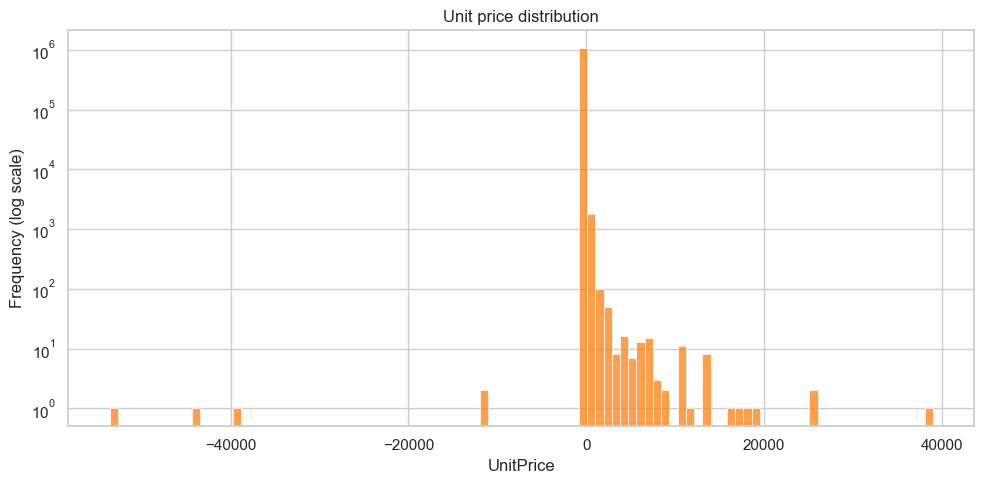

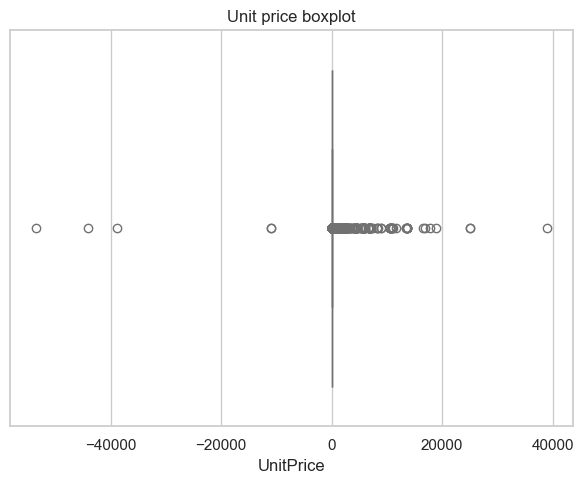

In [37]:
# Distribution of unit prices and count of non-positive values
price_issue_count = (df_clean['UnitPrice'] <= 0).sum()
print(f"Rows with UnitPrice <= 0: {price_issue_count}")

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df_clean['UnitPrice'], bins=100, ax=ax, color='#ff7f0e')
ax.set(title='Unit price distribution', xlabel='UnitPrice', ylabel='Frequency (log scale)')
ax.set_yscale('log')
save_fig('unit_price_histogram')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x=df_clean['UnitPrice'], ax=ax, color='#ffbb78')
ax.set(title='Unit price boxplot', xlabel='UnitPrice')
save_fig('unit_price_boxplot')
plt.show()
plt.close(fig)

> The distribution shows extreme skewness and a non-trivial number of non-positive prices. These anomalies likely stem from data entry errors or system adjustments. They must be removed before computing revenue-based features; however, exploring them here provides visibility on pricing inconsistencies.

### 3.6 Geographic breakdown

Understand transaction coverage by country.

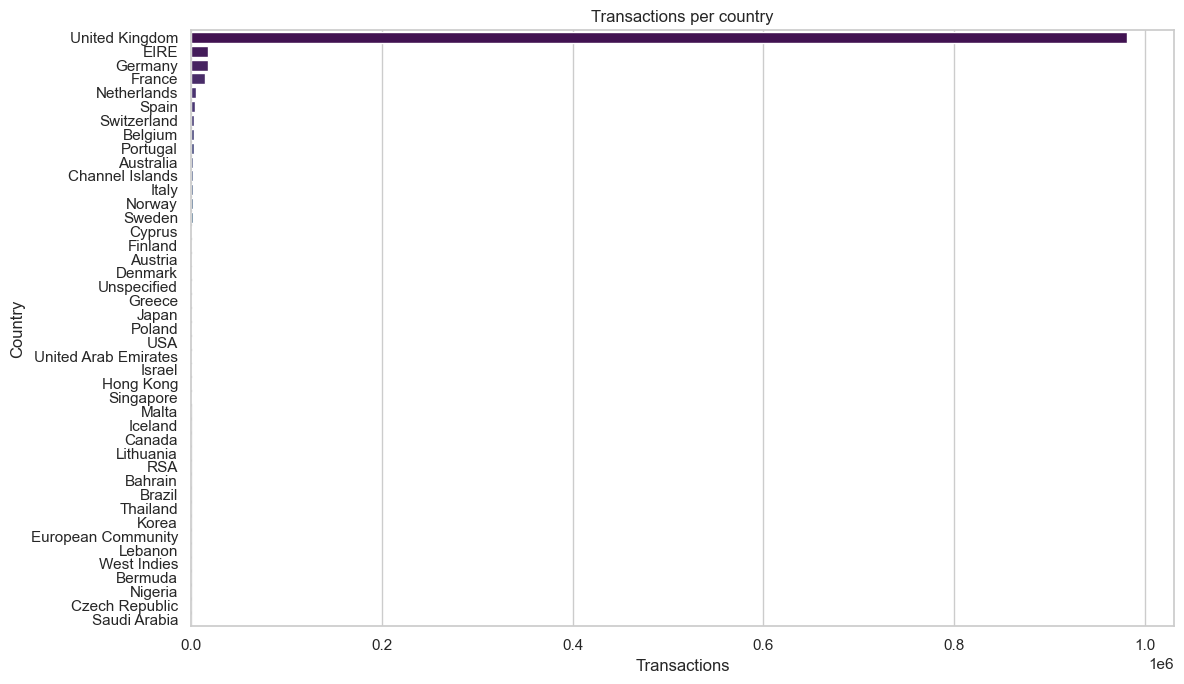

In [38]:
# Transaction counts by country
country_counts = df_clean['Country'].value_counts()
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=country_counts.values, y=country_counts.index, ax=ax, palette='viridis')
ax.set(title='Transactions per country', xlabel='Transactions', ylabel='Country')
save_fig('transactions_by_country')
plt.show()
plt.close(fig)

> The United Kingdom overwhelmingly dominates the dataset, with all other countries contributing only marginally. This imbalance means clustering will mostly reflect UK behavioural patterns. For modeling, non-UK customers may need special handling or filtering to avoid noise.

## 4. Univariate analysis

Histogram + boxplot for Quantity, UnitPrice, and TotalPrice distributions (transaction level only).

In [39]:
# Helper for hist + boxplot

def plot_univariate(series, title, fig_name, bins=60, log_scale=True):
    clean_series = series[series.notna()]
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
    sns.histplot(clean_series, bins=bins, ax=axes[0], color='#1f78b4')
    axes[0].set(title=f'Distribution of {title}', ylabel='Frequency')
    if log_scale:
        axes[0].set_yscale('log')
    sns.boxplot(x=clean_series, ax=axes[1], color='#a6cee3')
    axes[1].set(xlabel=title)
    save_fig(fig_name)
    plt.show()
    plt.close(fig)

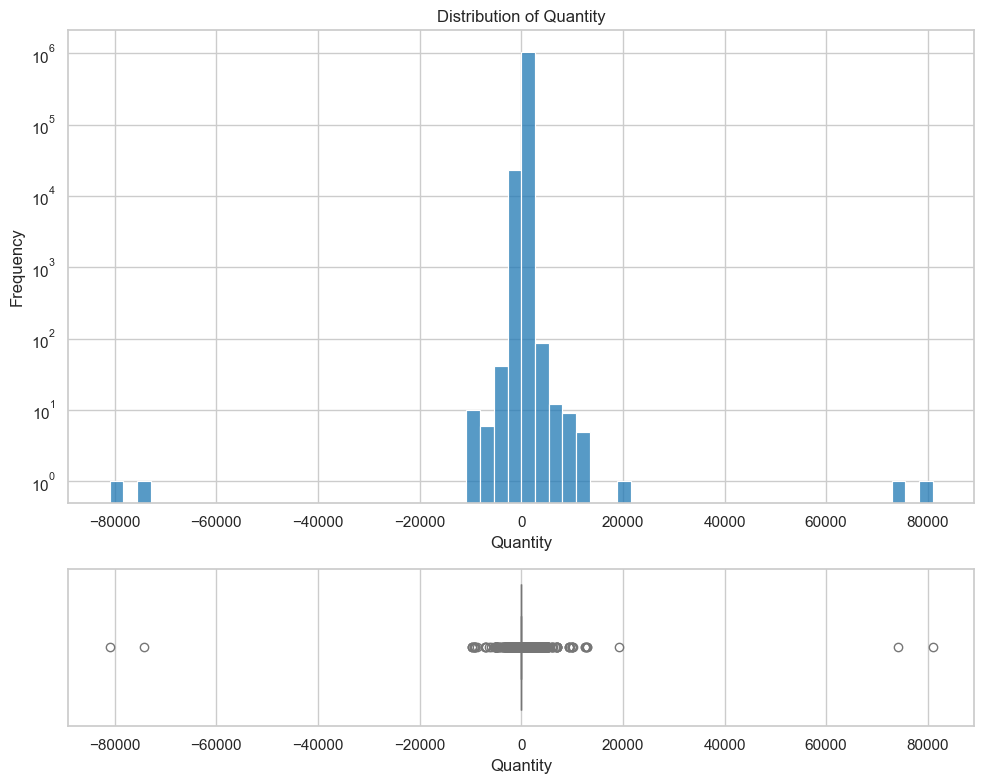

In [40]:
plot_univariate(df_clean['Quantity'], 'Quantity', 'quantity_distribution')

> Most transactions involve small quantities, while a long right tail corresponds to bulk purchases. This is expected in wholesale-like environments, where occasional large orders create heavy skew.

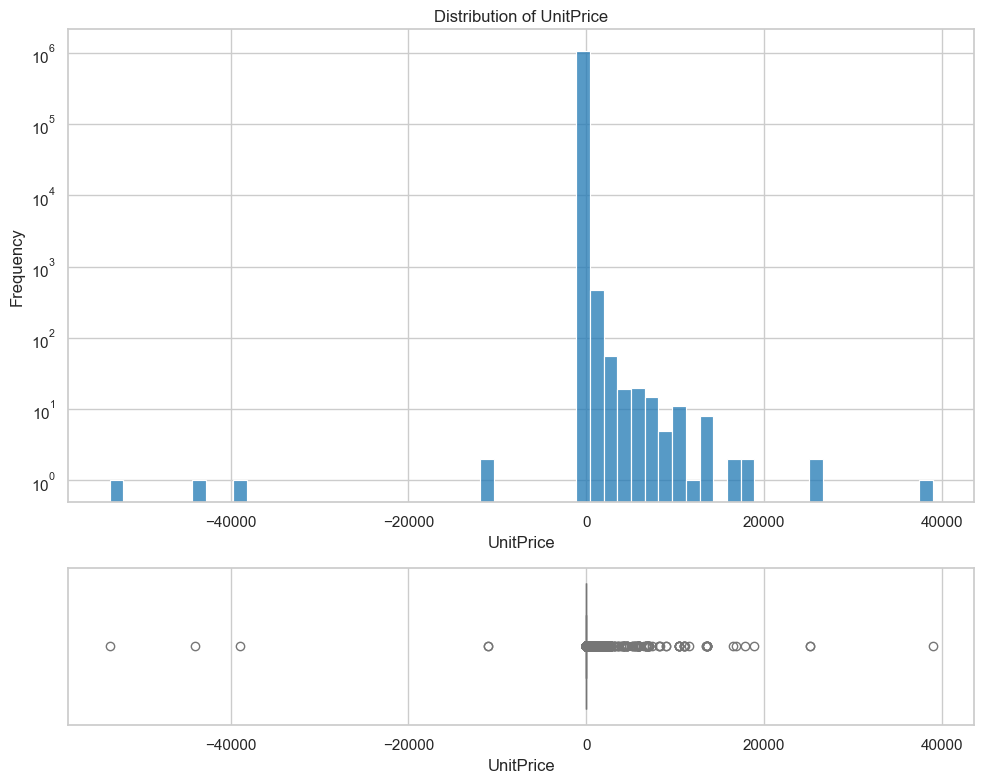

In [41]:
plot_univariate(df_clean['UnitPrice'], 'UnitPrice', 'unitprice_distribution')

> Prices are also highly skewed. Most items fall within a small price range, but a handful of items have extremely high prices, which may represent bundled products or mis-coded records.

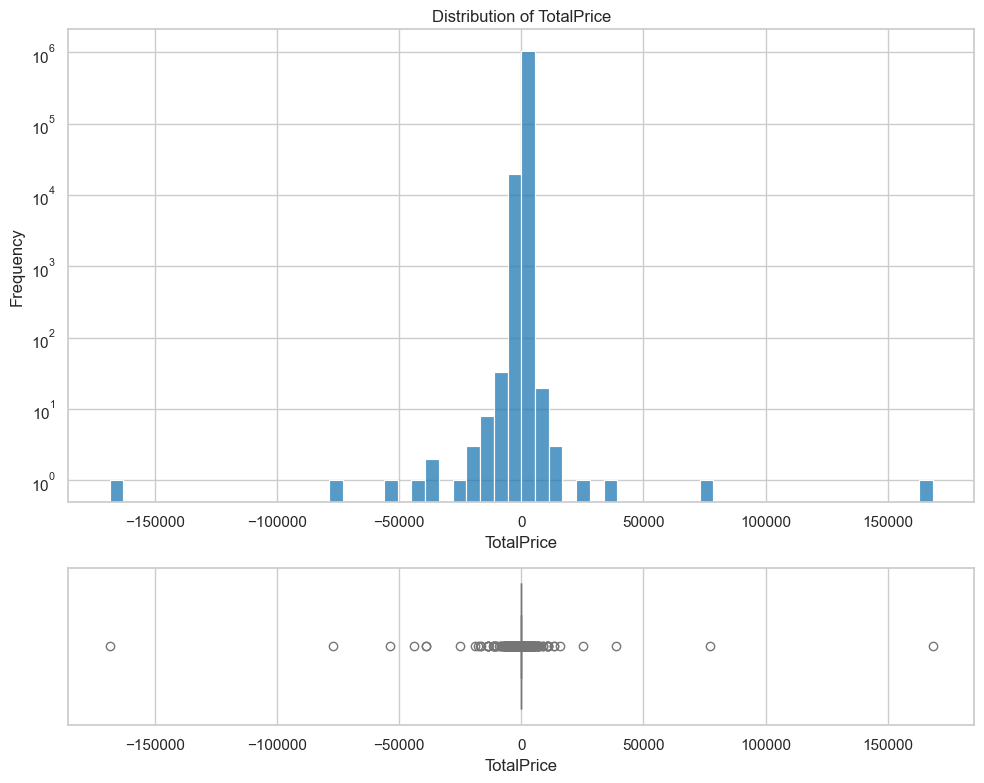

In [42]:
plot_univariate(df_clean['TotalPrice'], 'TotalPrice', 'totalprice_distribution')

> Invoice revenue is extremely concentrated. A small number of very large baskets drives a disproportionate share of revenue. This suggests strong customer heterogeneity—useful for building meaningful clusters later.

## 5. Time analysis

Derive calendar features and track monthly transaction count, quantity, and revenue.


In [43]:
# Time index for resampling (no in-place edits)
df_time = df_clean.set_index('InvoiceDate').sort_index()

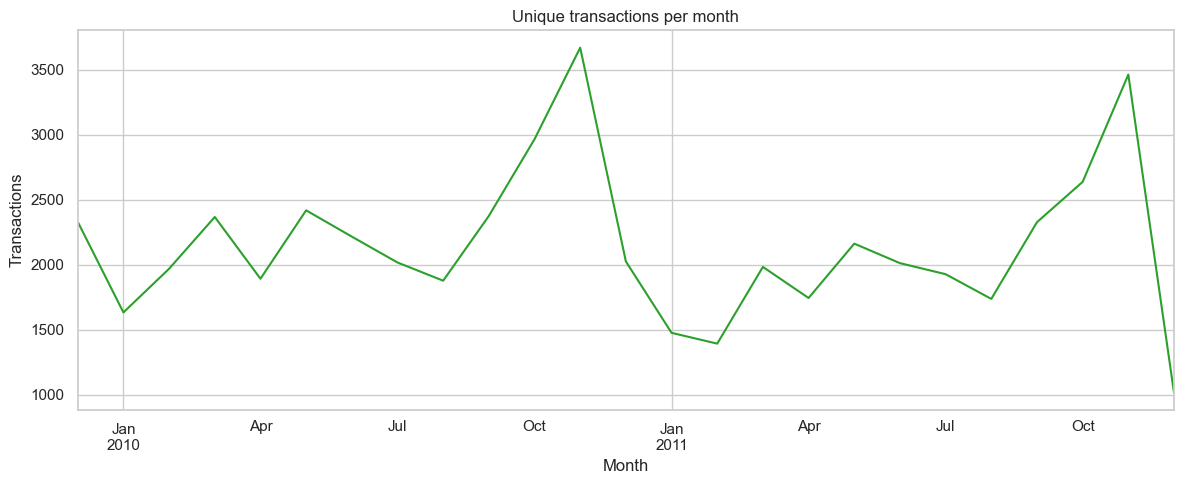

In [44]:
# Monthly transaction count
monthly_tx = df_time['Invoice'].resample('M').nunique()
fig, ax = plt.subplots(figsize=(12, 5))
monthly_tx.plot(ax=ax, color='#2ca02c')
ax.set(title='Unique transactions per month', xlabel='Month', ylabel='Transactions')
save_fig('monthly_transactions')
plt.show()
plt.close(fig)


> The time series shows clear seasonal peaks around the end of each year and reduced activity during the summer. These patterns match typical retail seasonality, confirming the reliability of the transaction timestamps.

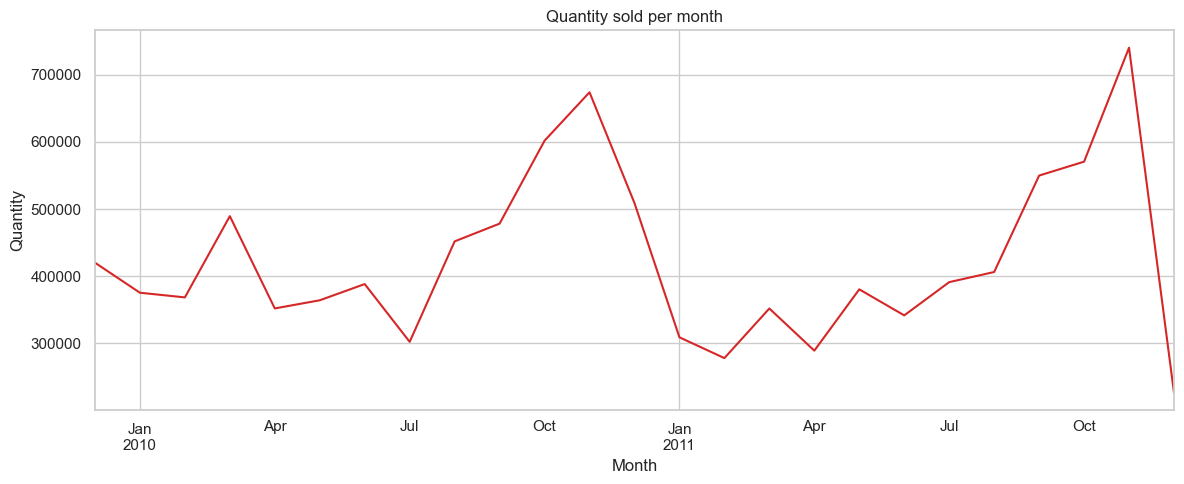

In [45]:
# Monthly quantity
monthly_qty = df_time['Quantity'].resample('M').sum()
fig, ax = plt.subplots(figsize=(12, 5))
monthly_qty.plot(ax=ax, color='#d62728')
ax.set(title='Quantity sold per month', xlabel='Month', ylabel='Quantity')
save_fig('monthly_quantity')
plt.show()
plt.close(fig)


> Quantity sold per month exhibits the same seasonal peaks as transaction count, but with sharper spikes. This indicates that not only are there more orders at certain times, but orders themselves tend to be larger.

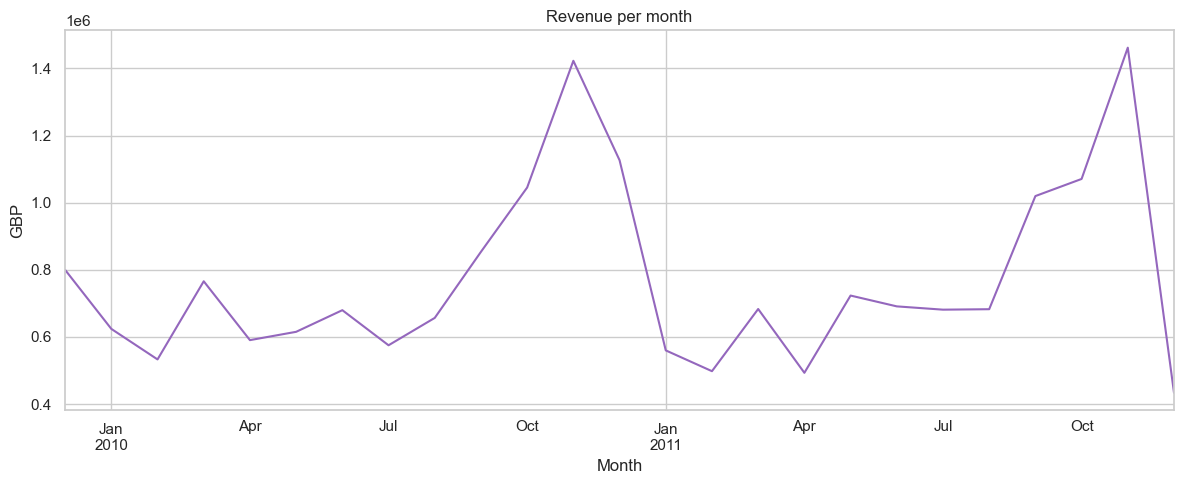

In [46]:
# Monthly revenue
monthly_revenue = df_time['TotalPrice'].resample('M').sum()
fig, ax = plt.subplots(figsize=(12, 5))
monthly_revenue.plot(ax=ax, color='#9467bd')
ax.set(title='Revenue per month', xlabel='Month', ylabel='GBP')
save_fig('monthly_revenue')
plt.show()
plt.close(fig)


> Revenue amplifies the seasonal effect even more, suggesting that high-value purchases cluster around holiday periods. This reinforces the importance of recency- and monetary-based features for segmentation.

## 6. Customer identifier diagnostics

Assess how many transactions carry a known `CustomerID` to anticipate segmentation coverage issues.

,CustomerIDStatus,transaction_count,percentage
0,Known CustomerID,824364,77.233127
1,Missing CustomerID,243007,22.766873


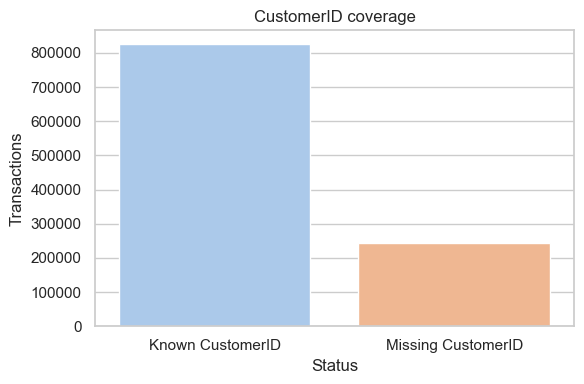

Unique identified customers: 5942


In [47]:
# CustomerID coverage
customer_id_status = (
    df_clean['CustomerID'].isna()
    .value_counts()
    .rename({False: 'Known CustomerID', True: 'Missing CustomerID'})
    .rename_axis('CustomerIDStatus')
    .reset_index(name='transaction_count')
)
customer_id_status['percentage'] = customer_id_status['transaction_count'] / len(df_clean) * 100
display(customer_id_status)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=customer_id_status, x='CustomerIDStatus', y='transaction_count', palette='pastel', ax=ax)
ax.set(title='CustomerID coverage', xlabel='Status', ylabel='Transactions')
save_fig('customerid_coverage')
plt.show()
plt.close(fig)

unique_customers = df_clean['CustomerID'].nunique(dropna=True)
print(f"Unique identified customers: {unique_customers}")

> A large share of transactions has no CustomerID (~23%), meaning segmentation will inherently exclude these rows. Still, the identified customers (~6k) provide enough volume for reliable clustering.

## 7. Product analysis


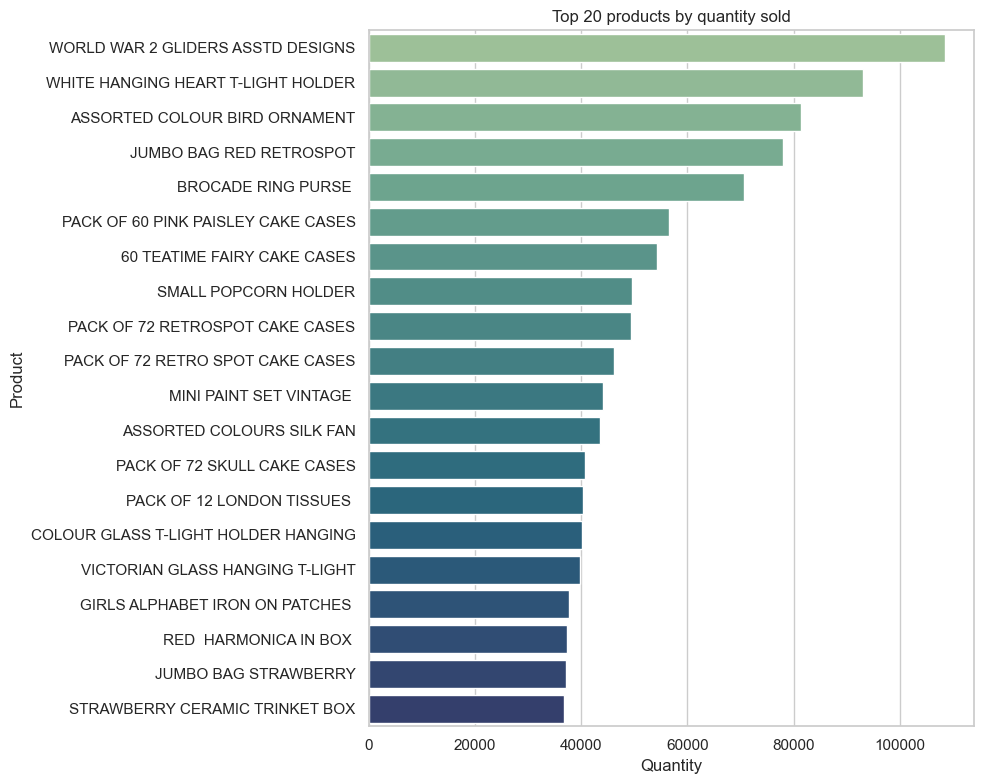

In [48]:
# Top 20 products by quantity
product_qty = (df_clean.groupby('Description')['Quantity']
               .sum()
               .sort_values(ascending=False)
               .head(20))
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=product_qty.values, y=product_qty.index, ax=ax, palette='crest')
ax.set(title='Top 20 products by quantity sold', xlabel='Quantity', ylabel='Product')
save_fig('top_products_quantity')
plt.show()
plt.close(fig)

> High-volume items are mostly low-cost gift and decor products, suggesting a strong “bestseller” dynamic driven by inexpensive recurring SKUs.

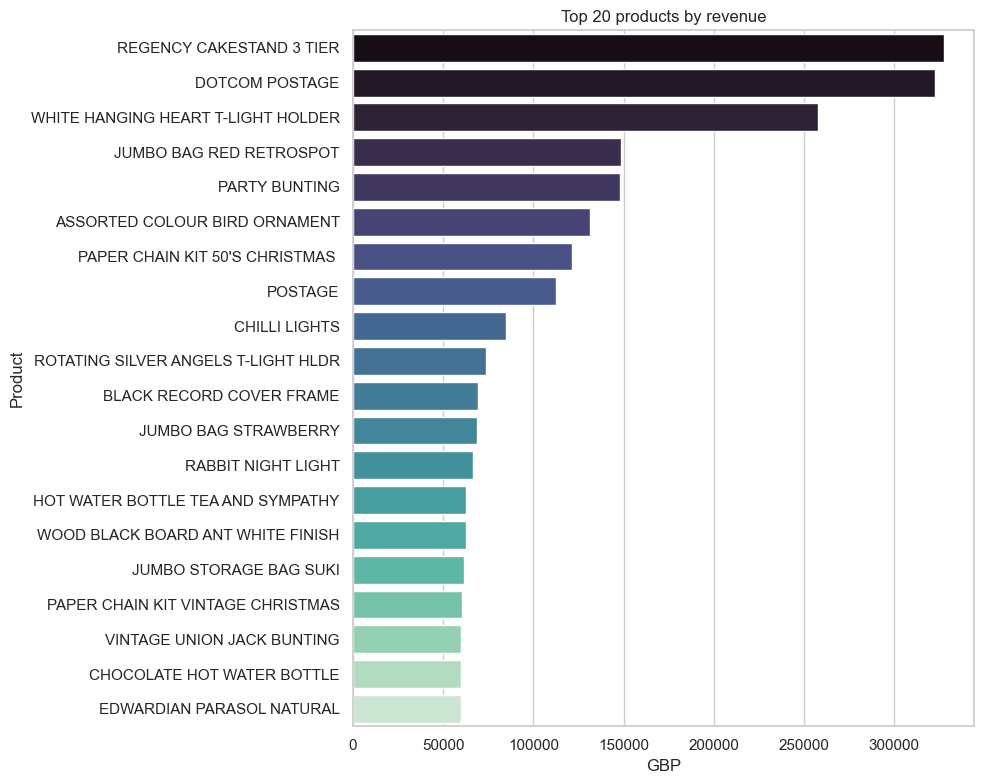

In [49]:
# Top 20 products by revenue
product_revenue = (df_clean.groupby('Description')['TotalPrice']
                   .sum()
                   .sort_values(ascending=False)
                   .head(20))
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=product_revenue.values, y=product_revenue.index, ax=ax, palette='mako')
ax.set(title='Top 20 products by revenue', xlabel='GBP', ylabel='Product')
save_fig('top_products_revenue')
plt.show()
plt.close(fig)

> The ranking shifts when looking at revenue: premium gift sets and postage fees dominate, showing that value generation differs significantly from unit volume.

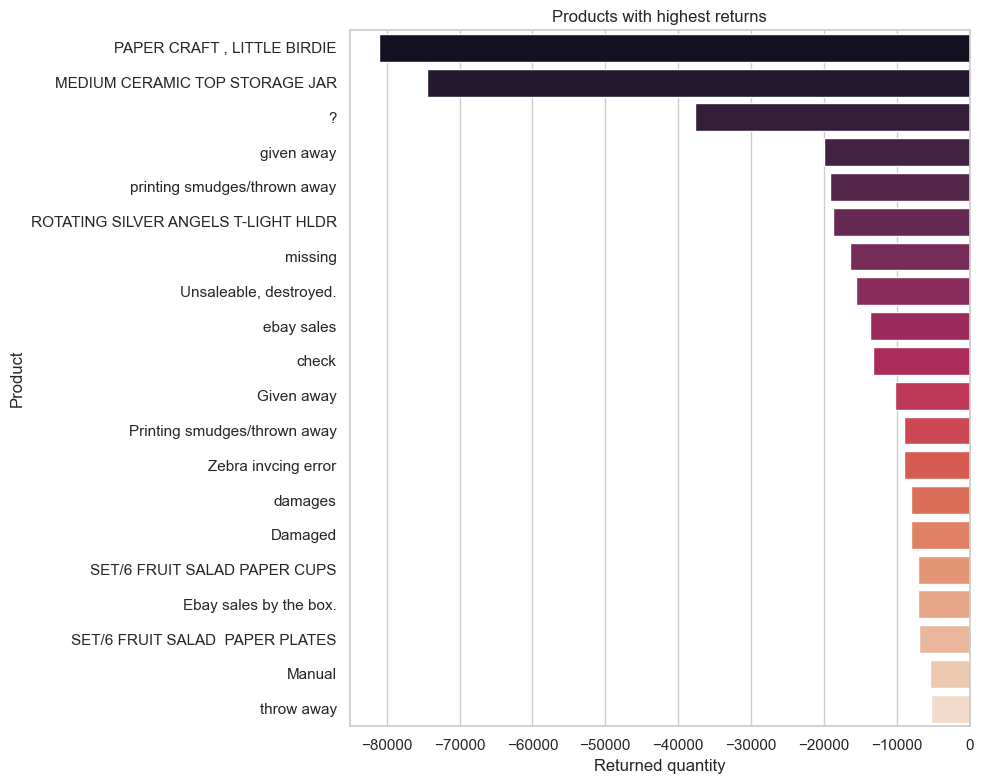

In [50]:
# Products with most returns
returned_products = (df_clean[df_clean['Quantity'] < 0]
                     .groupby('Description')['Quantity']
                     .sum()
                     .sort_values()
                     .head(20))
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=returned_products.values, y=returned_products.index, ax=ax, palette='rocket')
ax.set(title='Products with highest returns', xlabel='Returned quantity', ylabel='Product')
save_fig('top_returned_products')
plt.show()
plt.close(fig)

> Certain items repeatedly generate negative quantities, pointing to fragile or mis-labeled SKUs that may require quality checks or better catalog curation.

## 8. Country analysis


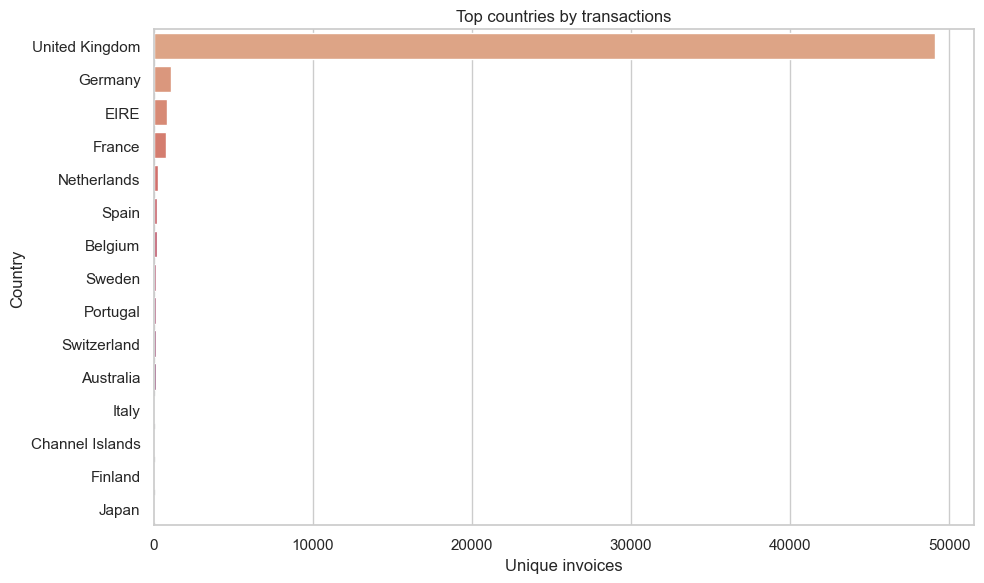

In [51]:
# Transactions by country (top 15)
country_transactions = (df_clean.groupby('Country')['Invoice']
                        .nunique()
                        .sort_values(ascending=False)
                        .head(15))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=country_transactions.values, y=country_transactions.index, ax=ax, palette='flare')
ax.set(title='Top countries by transactions', xlabel='Unique invoices', ylabel='Country')
save_fig('country_transactions_top15')
plt.show()
plt.close(fig)

> The UK overwhelmingly dominates the dataset, with only a handful of European markets showing meaningful volume. Most other countries represent marginal or one-off orders.

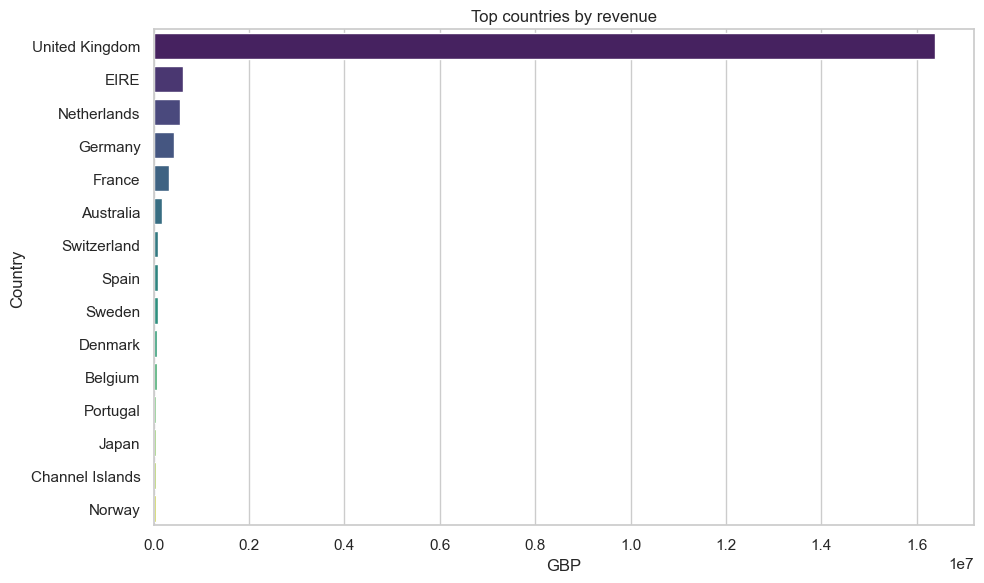

In [52]:
# Revenue by country (top 15)
country_revenue = (df_clean.groupby('Country')['TotalPrice']
                   .sum()
                   .sort_values(ascending=False)
                   .head(15))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, ax=ax, palette='viridis')
ax.set(title='Top countries by revenue', xlabel='GBP', ylabel='Country')
save_fig('country_revenue_top15')
plt.show()
plt.close(fig)

> Revenue concentration mirrors the transaction distribution but highlights a few export markets where orders generate more value per invoice.

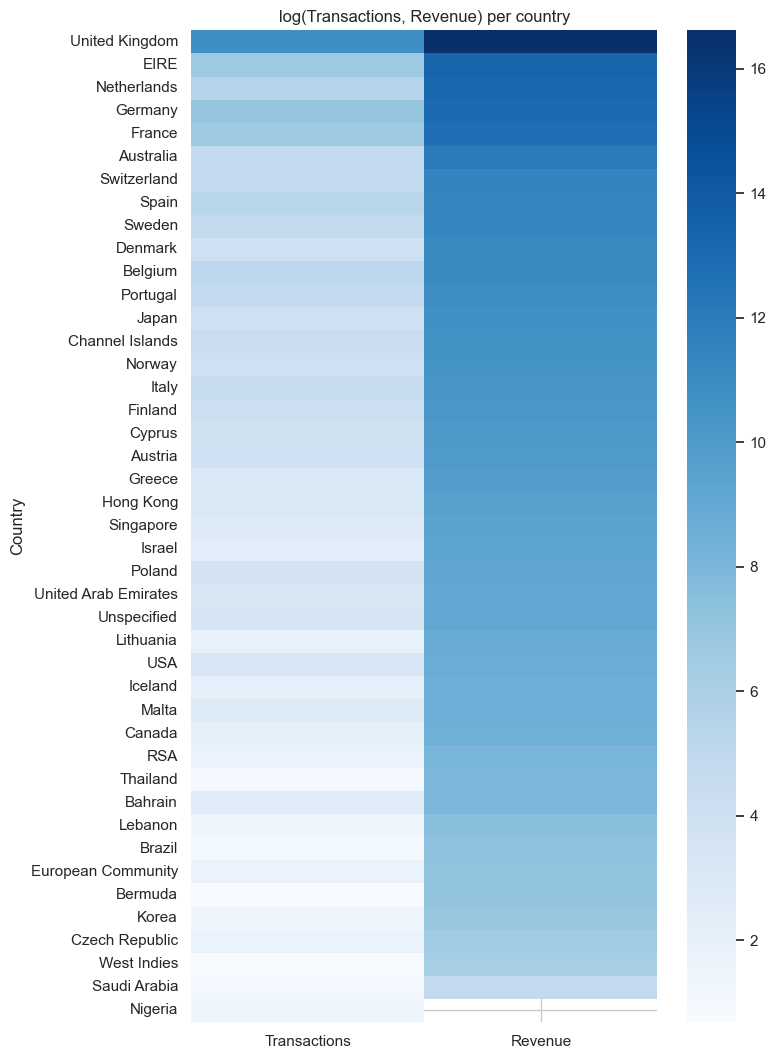

In [53]:
# Country heatmap (log scale)
country_metrics = (df_clean.groupby('Country')
                   .agg(Transactions=('Invoice', 'nunique'),
                        Revenue=('TotalPrice', 'sum')))
fig, ax = plt.subplots(figsize=(8, max(6, len(country_metrics) * 0.25)))
sns.heatmap(np.log1p(country_metrics).sort_values('Revenue', ascending=False),
            cmap='Blues', ax=ax)
ax.set(title='log(Transactions, Revenue) per country')
save_fig('country_metrics_heatmap')
plt.show()
plt.close(fig)

> The log-scale heatmap emphasizes the huge gap between the core UK market and the long tail of small countries, confirming a highly skewed geographic footprint.

## 9. Visual anomaly detection


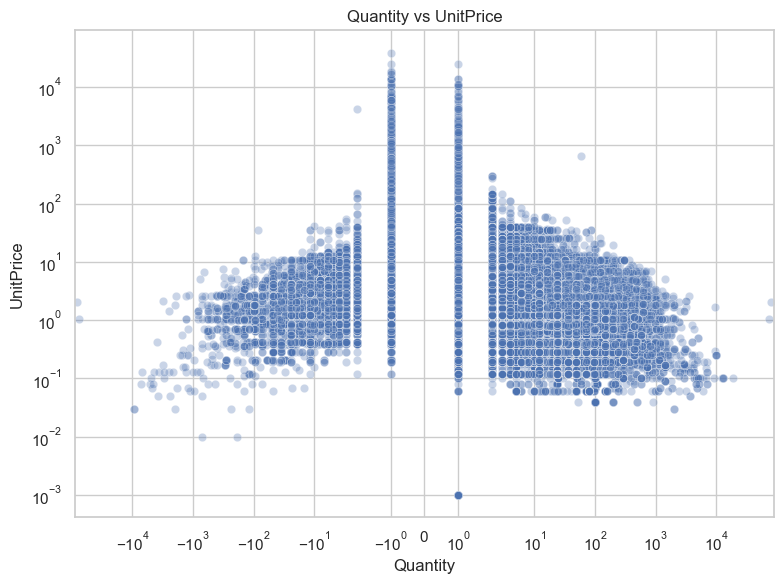

In [54]:
# Scatter Quantity vs UnitPrice
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Quantity', y='UnitPrice', alpha=0.3)
ax.set(title='Quantity vs UnitPrice', xlabel='Quantity', ylabel='UnitPrice')
ax.set_xscale('symlog')
ax.set_yscale('log')
save_fig('scatter_quantity_unitprice')
plt.show()
plt.close(fig)

> Daily retail activity is visible as dense clouds at low quantities, while a few extreme points reveal bulk adjustments or unusual pricing events.

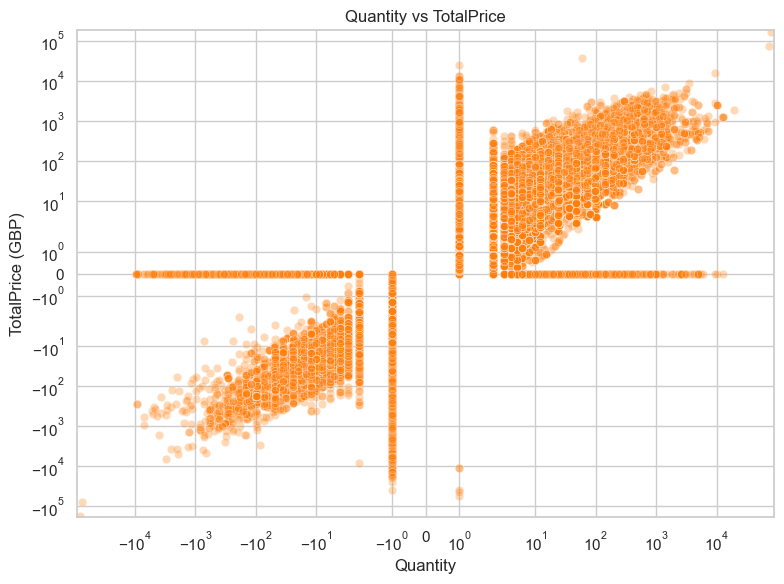

In [55]:
# Scatter Quantity vs TotalPrice
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Quantity', y='TotalPrice', alpha=0.3, color='#ff7f0e')
ax.set(title='Quantity vs TotalPrice', xlabel='Quantity', ylabel='TotalPrice (GBP)')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
save_fig('scatter_quantity_totalprice')
plt.show()
plt.close(fig)

> Most invoices follow a clear positive relationship between quantity and revenue, with a few low-value/high-quantity transactions suggesting deep discounts or invoice corrections.

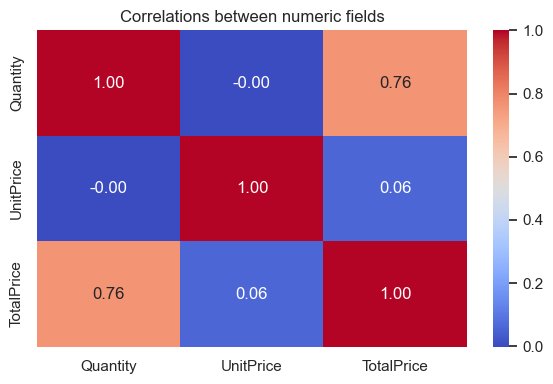

In [56]:
# Correlation heatmap
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']
corr = df_clean[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, fmt='.2f')
ax.set(title='Correlations between numeric fields')
save_fig('correlation_heatmap')
plt.show()
plt.close(fig)

> TotalPrice correlates strongly with Quantity but only weakly with UnitPrice, confirming that revenue is driven primarily by volume rather than pricing variation.

## 10. EDA conclusion

- **Detection highlights:** high missingness on `CustomerID`, observable duplicates, negative quantities/prices signalling returns or data-entry errors, cancellation invoices (prefix `C`), and highly skewed monetary distributions across time/countries/products.
- **Feature engineering ideas:** build RFM-style aggregations, time-based intensity metrics, return ratios, and geographic/product share indicators in the dedicated feature notebook.
- **Risks:** strong skew and seasonality require robust scaling; small-country noise and anonymous customers may bias unsupervised segmentation if not addressed during feature engineering.